In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error

from bruit_schiolerSilverman import schioler
from bruit_schiolerSilverman import jeuDeDonnees_schioler_bruite
from bruit_schiolerSilverman import jeuDeDonnees_schioler_bruite_inhomogene
from bruit_schiolerSilverman import affichage_illustratif_schioler

from bruit_schiolerSilverman import decoupageEnDeuxSousEnsembles
from bruit_schiolerSilverman import affichage_ensembles

from learning_schiolerSilverman import affichage_reseau_et_donnees
from learning_schiolerSilverman import apprentissage
from learning_schiolerSilverman import affichage_performances_et_donnees
from learning_schiolerSilverman import affiche_rms

# Régression par Perceptron Multicouches (Notions)
***

## Les données simulées "schioler" intervalle incomplet (version 1)

Dans cette partie nous présentons le jeu de données simulées "incomplet".

In [2]:
#np.random.seed(4);    # (Re)positionnement du random (ou pas)

In [3]:
nombreDeDonnees_appVal = 1000
nombreDeDonnees_test = 500
r_l=.5 # proportion de l'ensemble d'apprentissage 

# generation du jeu de donnees aleatoires
a1=-2; b1=-.75 ; a2=-.25 ; b2=1 ; a3=1.25 ; b3=2
xi,yi = jeuDeDonnees_schioler_bruite_inhomogene(nombreDeDonnees_appVal,a1=a1,b1=b1,a2=a2,b2=b2,a3=a3,b3=b3,sigma=.2)

# decoupage en deux ensembles d'apprentissage et de validation
x_app, y_app, x_val, y_val = decoupageEnDeuxSousEnsembles(xi,yi,r_l)
n_app = np.size(x_app,0)
n_val = np.size(x_val,0)

On a, par ailleurs, un **ensemble de test** .

In [4]:
# ensemble de test (performances en generalisation une fois l'apprentissage termine)
x_test,y_test = jeuDeDonnees_schioler_bruite(nombreDeDonnees_test,sigma=.2)
n_test = np.size(x_test,0)

quelques lignes de commandes fonctionnelles

In [5]:
# mise en forme pour MLPRegressor 
x_app = np.reshape(x_app, [n_app, 1])
x_val = np.reshape(x_val, [n_val, 1])
x_test = np.reshape(x_test, [n_test, 1])    

#### Affichage du jeu de données

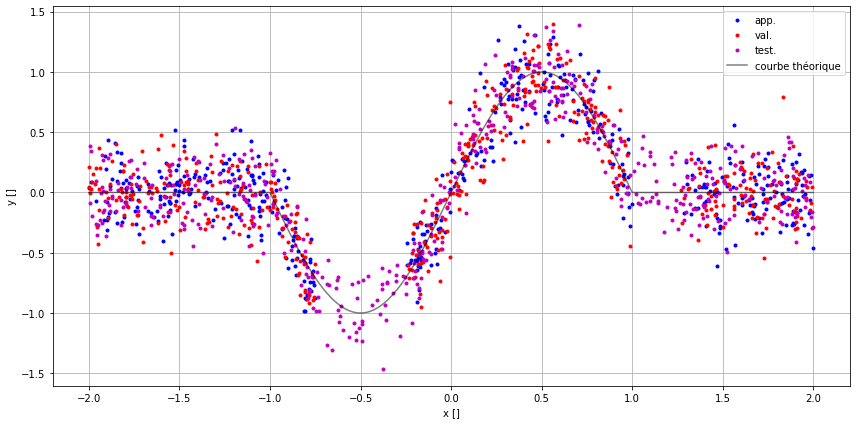

In [6]:
# Abscisse régulière pour l'affichage des courbes
n_maillage = 1000
x_maillage = np.linspace(-2,2,n_maillage).reshape(n_maillage,1) 

plt.figure(figsize=(12,6))
affichage_ensembles(x_app, y_app, x_val, y_val, x_test, y_test,schioler)

## Apprentissage i.e. estimation d'une fonction par MLP

### apprentissage d'un mlp

In [25]:
# Apprentissage pour un nombre de neurones en couche cachée
n_hidden = 3
# specification du modele
rgrsr = MLPRegressor(activation='tanh', hidden_layer_sizes = (n_hidden), warm_start='True',solver='lbfgs', learning_rate = 'adaptive',max_iter=1)

# apprentissage du modele
rgrsr, erreurs_app, erreurs_val, cpt_erreur_val_min = apprentissage(rgrsr,x_app, y_app,x_val, y_val,max_n_iter=500)

#### affichage des performances de l'apprentissage 

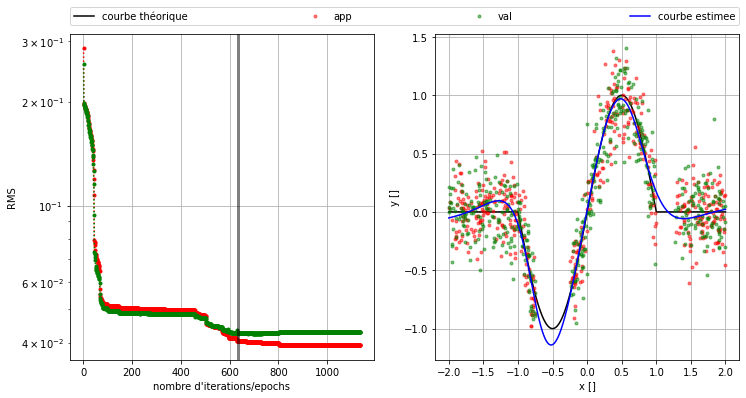

In [26]:
fig= plt.figure(figsize=(12,6))
affichage_performances_et_donnees(erreurs_app,erreurs_val,cpt_erreur_val_min,
                                  n_hidden,rgrsr,
                                  x_app,y_app,x_val,y_val,
                                  schioler,x_maillage)

In [27]:
affiche_rms(n_hidden,erreurs_app,erreurs_val,cpt_erreur_val_min)
print()

       m  err_app  err_val
       3  0.04054  0.04255



In [32]:
def get_internal(maillage,rgrsr):
    values=list()
    values.append(list())
    for zz in range(rgrsr.coefs_[1].shape[0]): 
        values.append(list())
    for x in maillage:
        inp =  np.array(x)
        tmp = inp
        tmp = rgrsr.coefs_[0].T.dot(tmp.T)  
        tmp = tmp + rgrsr.intercepts_[0].reshape(tmp.shape)
        tmp = np.tanh(tmp)
        for i in range(tmp.shape[0]):
            values[i].append([tmp[i]]*rgrsr.coefs_[1][i])
        #print(rgrsr.coefs_[1])
        tmp = rgrsr.coefs_[1].T.dot(tmp) 
        tmp = tmp +rgrsr.intercepts_[1].reshape(tmp.shape)
        values[-1].append(tmp)
    #print(values)
    return values

In [33]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

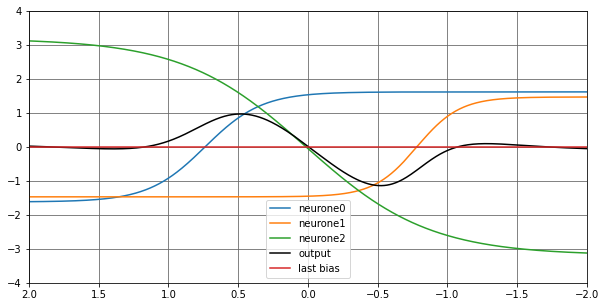

In [34]:
z = get_internal(x_maillage,rgrsr)
plt.xlim(right=-2)  # adjust the right leaving left unchanged
plt.xlim(left=2)
plt.ylim(bottom=-4)  # adjust the right leaving left unchanged
plt.ylim(top=4) 
plt.grid(b=True, which='major', color='#666666', linestyle='-')
for i,var in enumerate(z[:-1]): 
    plt.plot(x_maillage, var,label="neurone"+str(i))
plt.plot(x_maillage,z[-1],'k',label="output")
plt.plot(x_maillage,rgrsr.intercepts_[1]*np.ones(len(x_maillage)),label="last bias")
sum = list()
#for i in range(len(x_maillage)):
#    sum.append(z[0][i]+z[1][i]+z[2][i])
#plt.plot(x_maillage,sum,label="sum")
plt.legend()

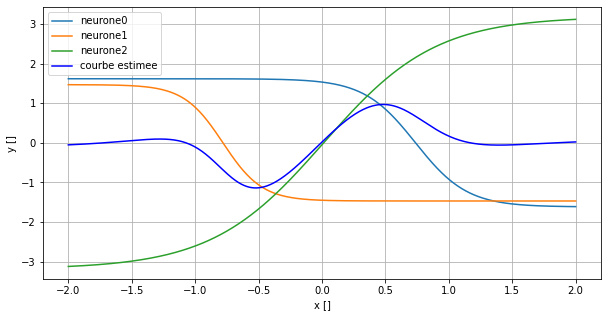

In [36]:
ax = plt.gca()
#ax.plot(x_maillage,sumz,'k-',label='courbe théorique')
#ax.plot(x_app,y_app,'r.',alpha=.5,label='app')
#ax.plot(x_val,y_val,'g.',alpha=.5,label='val')

for i,var in enumerate(z[:-1]): 
    ax.plot(x_maillage, var,label="neurone"+str(i))

# courbe estimee
ax.plot(x_maillage,rgrsr.predict(x_maillage),'b-',label='courbe estimee')
ax.grid(True)
ax.set_xlabel("x []")
ax.set_ylabel("y []")
ax.legend()

Bien qu'on ne le devrait pas, on va considérer l'ensemble de test et les performances associées.  
Cela devrait nous permettre de prendre du recul sur l'effet des paramètres d'apprentissage sur la généralisation. 

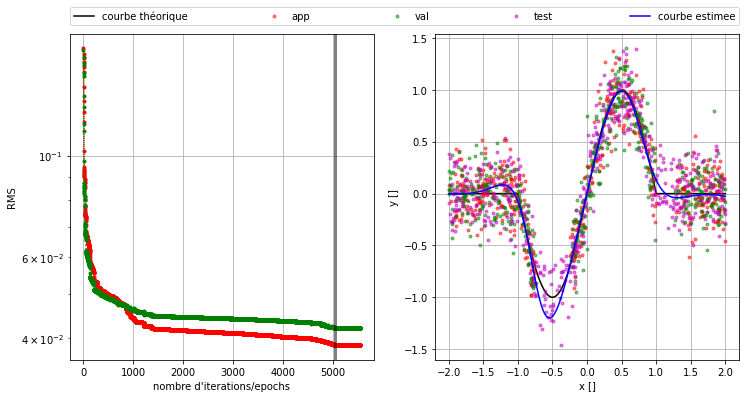

In [10]:
fig= plt.figure(figsize=(12,6))
affichage_performances_et_donnees(erreurs_app,erreurs_val,cpt_erreur_val_min,
                                  n_hidden,rgrsr,
                                  x_app,y_app,x_val,y_val,
                                  schioler,x_maillage,
                                  x_test, y_test)

In [11]:
affiche_rms(n_hidden,erreurs_app,erreurs_val,cpt_erreur_val_min,x_test=x_test,y_test=y_test,rgrsr=rgrsr)
print() 

       m  err_app  err_val      err_test
       9  0.03868  0.04208     (0.04441)



### apprentissage de plusieurs architectures

In [12]:
# Apprentissage pour un nombre de neurones en couche cachée
liste_n_hidden = list(range(1,10,2))

# initialisation
liste_rgrsr         = list()
liste_erreurs_app = list()
liste_erreurs_val = list()
liste_cpt_erreur_val_min  = list()

# specification du modele
for i,n_hidden in enumerate(liste_n_hidden): 
    rgrsr = MLPRegressor(activation='tanh', hidden_layer_sizes = (n_hidden), warm_start='True',solver='lbfgs', learning_rate = 'adaptive',max_iter=1)

    # apprentissage du modele
    rgrsr, erreurs_app, erreurs_val, cpt_erreur_val_min = apprentissage(rgrsr,x_app, y_app,x_val, y_val,max_n_iter=500)
    liste_rgrsr.append(rgrsr)
    liste_erreurs_app.append(erreurs_app)
    liste_erreurs_val.append(erreurs_val)
    liste_cpt_erreur_val_min.append(cpt_erreur_val_min)

#### affichage des performances  d'apprentissage

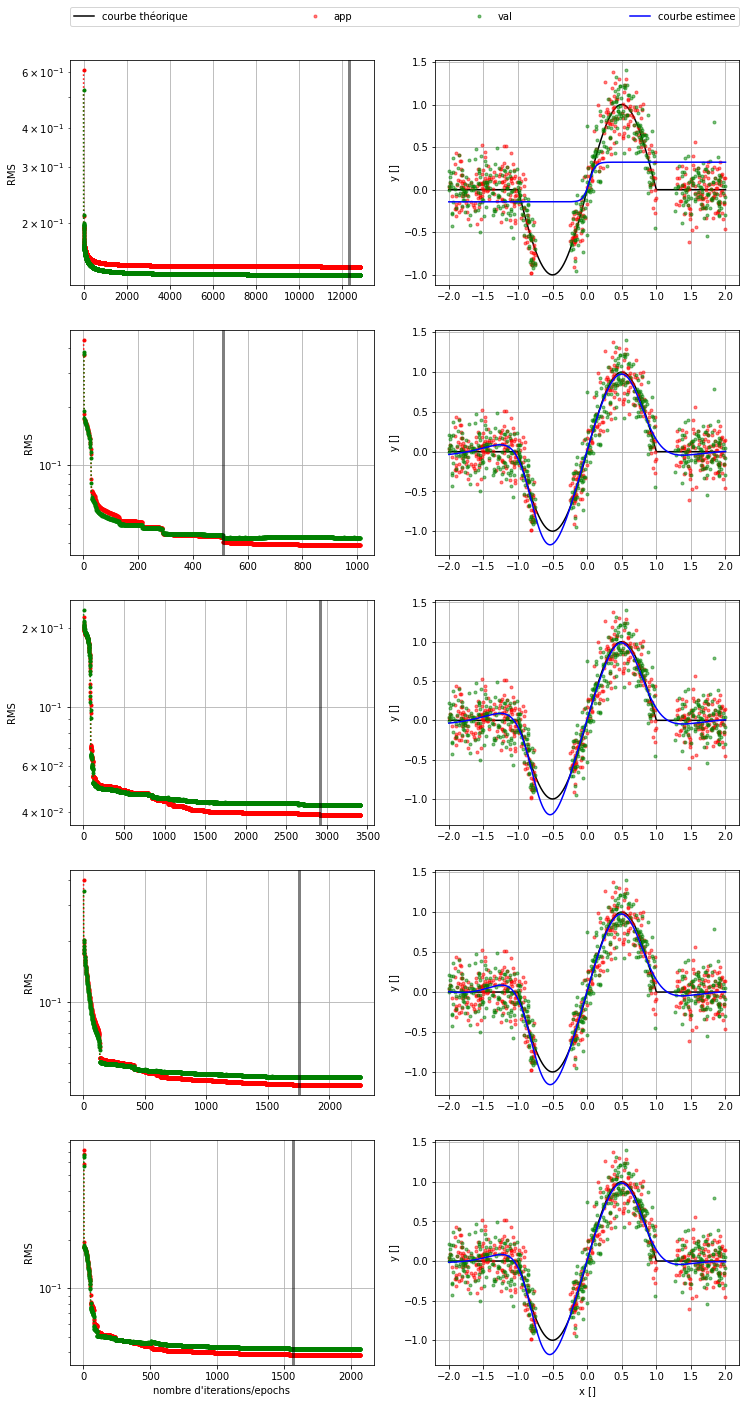

In [13]:
fig= plt.figure(figsize=(12,24))
affichage_performances_et_donnees(liste_erreurs_app,liste_erreurs_val,
                                  liste_cpt_erreur_val_min,
                                  liste_n_hidden,liste_rgrsr,
                                  x_app,y_app,x_val,y_val,
                                  schioler,x_maillage)
    

In [14]:
    affiche_rms(liste_n_hidden,liste_erreurs_app,liste_erreurs_val,liste_cpt_erreur_val_min)
    print()
    

       m  err_app  err_val
       1  0.14620  0.13765
       3  0.04035  0.04226
       5  0.03904  0.04250
       7  0.03887  0.04235
       9  0.03879  0.04216



Comme précédemment on va considérer l'ensemble de test et les performances associées.  
Là encore, bien qu'on ne le devrait pas, cela devrait nous permettre de prendre du recul sur l'effet des paramètres d'apprentissage sur la généralisation. 

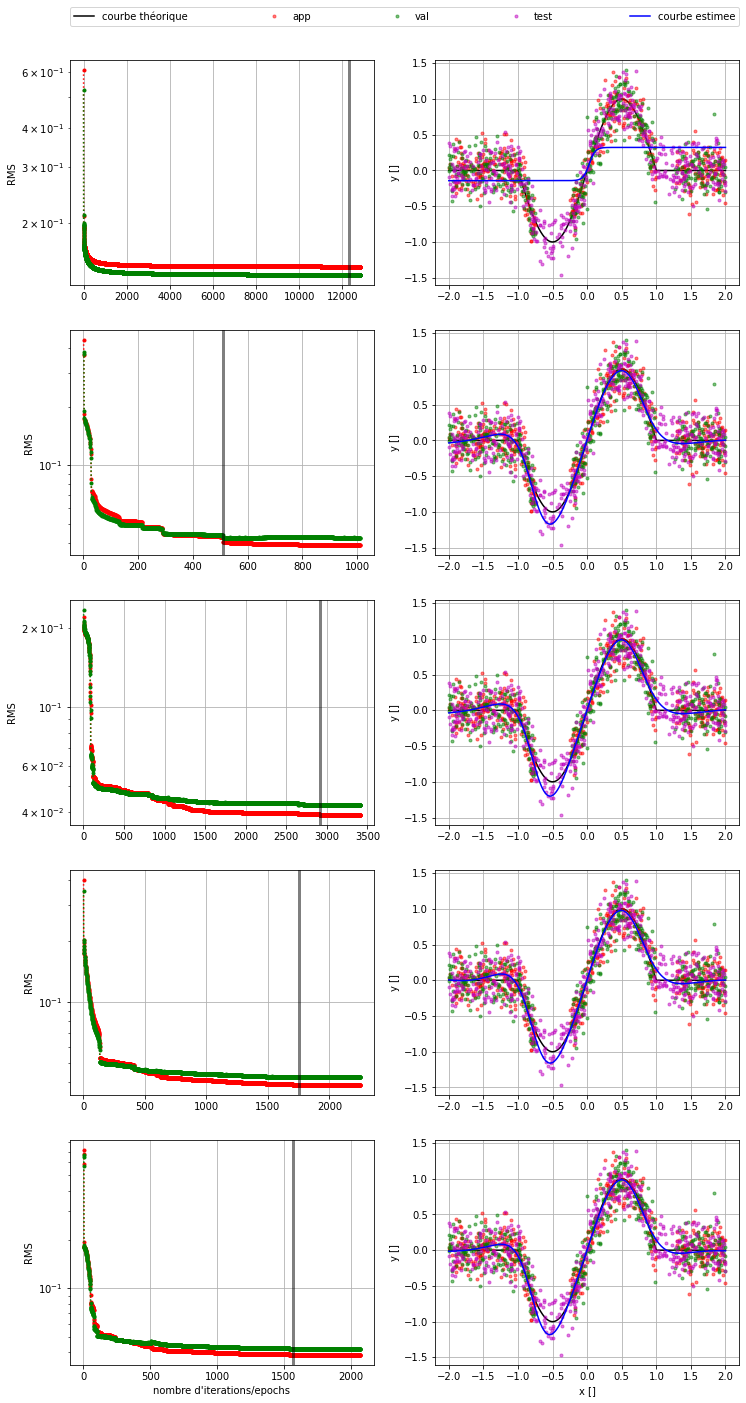

In [15]:
fig= plt.figure(figsize=(12,24))
affichage_performances_et_donnees(liste_erreurs_app,liste_erreurs_val,
                                  liste_cpt_erreur_val_min,
                                  liste_n_hidden,liste_rgrsr,
                                  x_app,y_app,x_val,y_val,
                                  schioler,x_maillage,
                                  x_test, y_test)

In [16]:
affiche_rms(liste_n_hidden,liste_erreurs_app,liste_erreurs_val,liste_cpt_erreur_val_min,x_test=x_test,y_test=y_test,rgrsr=liste_rgrsr)
print()

       m  err_app  err_val      err_test
       1  0.14620  0.13765     (0.19622)
       3  0.04035  0.04226     (0.04388)
       5  0.03904  0.04250     (0.04470)
       7  0.03887  0.04235     (0.04365)
       9  0.03879  0.04216     (0.04404)



In [17]:
err_app = [liste_erreurs_app[i][x] for i,x in enumerate(liste_cpt_erreur_val_min)]

In [18]:
err_val = [liste_erreurs_val[i][x] for i,x in enumerate(liste_cpt_erreur_val_min)]

In [19]:
err_test = [mean_squared_error(y_test.ravel(),rg.predict(x_test)) for rg in liste_rgrsr]
err_test

[0.19621681204498267,
 0.043884626625440355,
 0.044704494201077624,
 0.043646891411867304,
 0.044040457525107435]

In [21]:
domaine1 = ((x_test>=b1) * (x_test<=a2)).reshape(-1)
err_domaine1 =  [mean_squared_error(y_test[domaine1].ravel(),rg.predict(x_test[domaine1])) for rg in liste_rgrsr]
err_domaine1

[0.6236648216965038,
 0.056196091286601094,
 0.0614846539149053,
 0.0539019654679279,
 0.05750185997426282]

In [22]:
domaine2 = ((x_test>=b2) * (x_test<=a3)).reshape(-1)
err_domaine2 =  [mean_squared_error(y_test[domaine2].ravel(),rg.predict(x_test[domaine2])) for rg in liste_rgrsr]
err_domaine2

[0.10925753293503429,
 0.03951039076559847,
 0.039446200097606285,
 0.03959131131500378,
 0.040081540314581464]

In [23]:
domaine3 = ((x_test<b1) + (x_test>a2) * (x_test<b2) + (x_test>a3)).reshape(-1)
err_domaine3 =  [mean_squared_error(y_test[domaine3].ravel(),rg.predict(x_test[domaine3])) for rg in liste_rgrsr]
err_domaine3

[0.15031674204965154,
 0.04269169363071706,
 0.0430299760667811,
 0.042681660568890986,
 0.04267921246367488]

In [24]:
import plotly.graph_objects as go



# Create traces
fig = go.Figure()

fig.add_trace(go.Scatter(x=liste_n_hidden, y=err_app,
                    mode='lines+markers',
                    name='train'))
fig.add_trace(go.Scatter(x=liste_n_hidden, y=err_val,
                    mode='lines+markers',
                    name='val'))

fig.add_trace(go.Scatter(x=liste_n_hidden, y=err_test,
                    mode='lines+markers',
                    name='test global '))

fig.add_trace(go.Scatter(x=liste_n_hidden, y=err_domaine1,
                    mode='lines+markers',
                    name='test domaine 1'))

fig.add_trace(go.Scatter(x=liste_n_hidden, y=err_domaine2,
                    mode='lines+markers',
                    name='test domaine 2'))

fig.add_trace(go.Scatter(x=liste_n_hidden, y=err_domaine3,
                    mode='lines+markers',
                    name='test domaine entrainement'))

fig.show()